# BERT Plus a Classifier

This notebook puts together a BERT model to encode then get word embeddings at a token level for the ChemE dataset (BETO). It then collates those embeddings, and sends them to a classifier that is just a default model from scikit learn, which is to be decided as to which model is best. This classifier will then classify the individual tokens based on the input vectors. It's nice to have this option, as we can remove all PAD tokens from classification I guess? 

In [2]:
import torch
import random
import os
import nltk
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk import tokenize
from transformers import BertTokenizer

In [3]:
def extract_xy(df):
    """
    This method extracts and correctly aranges the NER training x-values (tokens)
    and y-values (BESIO labels) from a pandas dataframe containing labeled NER
    data

    Parameters:
        df (pandas DataFrame, required): Dataframe loaded via pd.read_excel() on
            a labeled NER dataset

        endings_dict (dictionary, required): Dictionary containing the indicies
            where each sentence in each line of tokens ends.

    Returns:
        two lists of identical shape. One contains all the words that were tokenized for labeling
        and the other contains all the labels of those tokenized words.
    """
    labeled = []
    columns = df.columns
    new_df = pd.DataFrame()
    all_tokens = []
    besio = []
    mol = []
    IorO = []
        
    for idx, column in enumerate(columns):
        # find every column that starts with 'name'
        if column.startswith('name'):

            # check if the entry in 'name' cell is a str
            if isinstance(df[column][0], str):
                tokens = df[columns[idx + 1]].values
                #find the index where the tokens become NaNs, and chop the token length down to that size. 
                l = 0
                for entries in tokens: 
                    if type(entries) == str:
                        l += 1
                all_tokens.append(tokens[:l])
                df[columns[idx+2]].replace(np.nan, 'O', inplace = True)
                besio.append(df[columns[idx+2]][:l].values)
                df[columns[idx+3]].replace(np.nan, '', inplace = True)
                mol.append(df[columns[idx+3]][:l].values)
                df[columns[idx+4]].replace(np.nan, '', inplace = True)
                IorO.append(df[columns[idx+4]][:l].values)

    i = 0
    label_values = []
    while i < len(besio):
        label_values.append([])
        for j in range(len(besio[i])):
            #Strip unintentional whitespace from all entries:
            besio[i][j] = besio[i][j].replace(" ", "")
            mol[i][j] = mol[i][j].replace(" ", "")
            IorO[i][j] = IorO[i][j].replace(" ", "")
            
            if besio[i][j].upper() == 'O':
                label_values[i].append(besio[i][j].upper())
            if mol[i][j].upper() == 'PRO':
                label_values[i].append(besio[i][j].upper()+'-'+mol[i][j].upper())
            if IorO[i][j].upper() == 'I' or IorO[i][j].upper() == 'O':
                #The below does not handle cases where BESIO or MOL has errors though...
                if mol[i][j].upper() != 'PRO':
                    label_values[i].append(besio[i][j].upper()+'-'+mol[i][j].upper()+'-'+IorO[i][j].upper())
                else: 
                    print("Weird. This Property is organic or inorganic? LOL")
            #PRIME OPPORTUNITY FOR ERROR HANDLING - IF ANYTHING NOT IN THE ABOVE CATS, SOMETHING IS WRONG
            
        i += 1   
    return all_tokens, label_values

In [4]:
#Ok, need another def function that takes in a list of tokens, and a list of labels, and returns them each as a list of strings
def tokenized_to_string(token_list):
    token_stringlist = []
    for paper_tokens in token_list:
        paper_string = ""
        for i in paper_tokens:
            #This is basically an 'unsplit' method lol
            paper_string += (str(i) + " ")
        token_stringlist.append(paper_string)
    return token_stringlist

In [5]:
def labeled_sheets_to_listed_tokens(directory_url):
    """This function opens a directory of labeled excel sheets from David's excel sheets and returns the tokens as a list 
    of strings fully combined on a document level. It returns a list of strings, with each string being a full document."""
    files = os.listdir(directory_url)
    token_list = []
    label_list = []
    sent_labels = []
    for file in files:
        df = pd.read_excel(directory_url+file)
        token, label = extract_xy(df)
        token_list += (tokenized_to_string(token))
        label_list += (label)
    #Now we tokenize each paper by sentences using NLTK:
    #we will also restructure labels to be ordered by sentences. 
    for i in range(len(token_list)):
        sentences = tokenize.sent_tokenize(token_list[i])
        token_list[i] = sentences
        short_term_labels = []
        for j in range(len(token_list[i])):    
            length = len(token_list[i][j].split())
            short_list = label_list[i][:length]
            short_term_labels.append(short_list)
            del(label_list[i][:length])
        sent_labels.append(short_term_labels)
    return token_list, sent_labels

In [6]:
dir_url = '/Users/Jonathan/Desktop/LabeledChemEData/Labeled_Sheets/'
list_o_tokens, list_o_labels = labeled_sheets_to_listed_tokens(dir_url)

Weird. This Property is organic or inorganic? LOL
Weird. This Property is organic or inorganic? LOL


In [7]:
def drop_empty_sentences(token_list, label_list, label_dict):
    """This function is a form of undersampling an overshadowing case, as it is dropping all examples of sentences where only O labels exist."""
    labels_list = list(label_dict.keys())
    flip = 0
    list_of_deletions = []
    del_counter = 0
    for i in range(len(labels_list)):
        if labels_list[i] == 'O':
            del(labels_list[i])
            flip = 1
        if flip == 1:
            break
    for i in range(len(token_list)):
        for j in range(len(token_list[i])):
            if any(x in label_list[i][j] for x in labels_list):
                pass
            else:
                list_of_deletions.append([i,j])
    print(list_of_deletions)
    while len(list_of_deletions) != 0:
        i,j = list_of_deletions[-1]
        del(label_list[i][j])
        del(token_list[i][j])
        del(list_of_deletions[-1])
        del_counter += 1
    print("Total deleted sentences = " + str(del_counter))
    return token_list, label_list

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

In [9]:
def max_encoded_length(token_list):
    max_len = 0
    len_list = []
    for papers in token_list:
        for sentences in papers:
            input_ids = tokenizer.encode(sentences, add_special_characters = True)
            max_len = max(max_len, len(input_ids))
            len_list.append(len(input_ids))
            
    return max_len, len_list

In [10]:
def delete_sentences(token_list, label_list, print_pop = False, max_length = 150):
    i = 0
    #lets use pop to remove these long sentences
    while i < len(token_list):
        list_of_j = []
        j = 0
        while j < len(token_list[i]):
            input_ids = tokenizer.encode(token_list[i][j], add_special_tokens = True)
            if len(input_ids) > 150:
                print("Found item length: " + str(len(input_ids)))
                list_of_j.append(j)
            j += 1
        k = len(list_of_j)-1
        #Gotta count backwards so we don't disturb the list structure
        while k > -1:
            if print_pop:
                print(token_list[i].pop(list_of_j[k]))
                print(label_list[i].pop(list_of_j[k]))
            else:
                token_list[i].pop(list_of_j[k])
                label_list[i].pop(list_of_j[k])
            k = k - 1
        i += 1 
    return token_list, label_list

In [11]:
#Not sure this is necessary if we don't train the full BERT model, but it's possible.
short_tokens, short_labels = delete_sentences(list_o_tokens, list_o_labels)

Found item length: 181
Found item length: 189
Found item length: 172
Found item length: 270
Found item length: 178
Found item length: 191
Found item length: 171
Found item length: 151
Found item length: 235
Found item length: 161
Found item length: 509
Found item length: 174
Found item length: 207
Found item length: 248
Found item length: 180
Found item length: 155
Found item length: 165
Found item length: 173


There are two label mapping dictionaries that take us from labels to numbers. One captures all of the subtleties of the BIO tagging scheme, and one deletes the BIO tags, and results in just O, MOL, PRO, and PAD/0 tags.

In [12]:
#Maybe we'll get back to this someday
label_mapping = {'O': 13, "B-MOL-O": 1, "I-MOL-O": 2, "E-MOL-O": 3,
                "S-MOL-O": 4, "B-MOL-I": 5, "I-MOL-I": 6, "E-MOL-I": 7,
                "S-MOL-I": 8, "B-PRO": 9, "I-PRO": 10, "E-PRO": 11, "S-PRO": 12,
                'PAD': 0}

In [13]:
#Long term we should absolutely consider getting rid of S, E labels
#For now, let's change O to not be the same as PAD, and see if that helps.
small_label_mapping = {'O': 3, "B-MOL-O": 1, "I-MOL-O": 1, "E-MOL-O": 1,
                "S-MOL-O": 1, "B-MOL-I": 1, "I-MOL-I": 1, "E-MOL-I": 1,
                "S-MOL-I": 1, "B-PRO": 2, "I-PRO": 2, "E-PRO": 2, "S-PRO": 2,
                'PAD': 0}


Part of the reason why we want to expand the input labels at the same level as the tokens is to make sure we have well-alligned labels and tokens for our later work when we pass both the input labels, as well as the encoded token vectors together to the final classifier.

In [14]:
def tokenize_and_align_lables(list_of_tokens, list_of_labels, encoding_dict, max_sent_length = 155):
    """"""
    input_ids = []
    attention_masks = []
    label_shapes = []
    no_pad_labels = []
    count = 0

    for abstracts, abst_labels in zip(list_of_tokens, list_of_labels):
        for sentences, sent_labels in zip(abstracts, abst_labels):
            encoded_dict = tokenizer.encode_plus(
                                        sentences,
                                        add_special_tokens = True,
                                        max_length = max_sent_length,
                                        pad_to_max_length = True,
                                        return_attention_mask = True,
                                        return_tensors = 'pt'
            )
            #Ok, now we get our labels based on encoded sizes. 
            #Make this a standalone function later instead of nesting
            #Need to start the CLS token to every label. 
            #This CLS token should be a int 0, to keep label
            #length matching consistent with the tokenized sentence
            extend_sent_labels = [0]


            #I Bet the problem with things being read in is the difference in length of 
            #however this chunks sentences versus how the labels were originally split.

            for word, label in zip(sentences, sent_labels):
                tokenized_word = tokenizer.tokenize(word)
                #Find out how many chunks each word gets broken into
                n_subwords = len(tokenized_word)
                #Extend the length of the labels to match new word length
                #Put label in brackets so it knows you want n_subwords entries
                #of label, not label times n_subwords
                extend_sent_labels.extend([label]*n_subwords)

            #In order to know just how much to bias the dataset for each label, we need to know how many of each we have. 
            no_pad_labels.extend(extend_sent_labels)

            #This handles increasing the length for padding and sep tokens
            #Go all the way to 155. Padding and  SEP should both be PAD tokens in label form
            #Because the key map will switch them to a 0. 
            extend_sent_labels.extend(['PAD']*(155-len(extend_sent_labels)))    
    #
            #Next step, we need to use the dictionary lookup
            #to replace all the values from this list to become 
            #numbers. for loops to go through the whole list. 
            for i in range(len(extend_sent_labels)):
                if extend_sent_labels[i] in encoding_dict.keys():
                    #Replace the label in extend_set_labels[i] from dict
                    extend_sent_labels[i] = encoding_dict[extend_sent_labels[i]]
            #print(extend_sent_labels)
            #Then, we make the labels list into a tensor.
            #extend_sent_labels = torch.tensor(extend_sent_labels)
            test_list = []
            test_list.append(extend_sent_labels)
            test_list = torch.tensor(test_list)
            #Build our attention mask, labels, and input ids of each item.
            label_shapes.append(test_list)
            input_ids.append(encoded_dict['input_ids'])
            attention_masks.append(encoded_dict['attention_mask'])

    print(len(label_shapes[1]))
    print(len(input_ids[1]))
    print(len(attention_masks[1]))

    #Make lists we just built into tensors
    input_ids = torch.cat(input_ids, dim = 0)
    attention_masks = torch.cat(attention_masks, dim = 0)
    labels = torch.cat(label_shapes, dim = 0)

    print("Original Sentence: ", list_of_tokens[0][0])
    print("Tokenized IDs: ", input_ids[0])
    print("Extended Labels: ", labels[0])
    
    return input_ids, attention_masks, labels

In [15]:
input_tokens, attention_mask, input_labels = tokenize_and_align_lables(short_tokens, short_labels, small_label_mapping)

1
1
1
Original Sentence:  In the interaction between gas molecules with single-walled carbon nanotube (SWCNT) we show that as a result of collisions the gas scattering contributes with an important background signal and should be considered in SWCNT-based gas sensors.
Tokenized IDs:  tensor([  101,  1999,  1996,  8290,  2090,  3806, 10737,  2007,  2309,  1011,
        17692,  6351, 28991, 28251,  2063,  1006, 25430,  2278,  3372,  1007,
         2057,  2265,  2008,  2004,  1037,  2765,  1997, 28820,  1996,  3806,
        17501, 16605,  2007,  2019,  2590,  4281,  4742,  1998,  2323,  2022,
         2641,  1999, 25430,  2278,  3372,  1011,  2241,  3806, 13907,  1012,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0

Now we need to load the tokens, labels, and the generated attention mask into a dataset and dataloader, to reduce load on the computer's memory.

In [16]:
from torch.utils.data import TensorDataset

In [17]:
dataset = TensorDataset(input_tokens, attention_mask, input_labels)

In [18]:
from torch.utils.data import DataLoader, RandomSampler

In [19]:
batch_size = 32
dataloader = DataLoader(dataset,
                        sampler = RandomSampler(dataset),
                        batch_size = batch_size
                        )

In [20]:
from transformers import BertModel, AdamW, BertConfig

In [21]:
model = BertModel.from_pretrained(
        "bert-base-uncased",
        output_attentions = False, #Whether model returns attention weights
        output_hidden_states = False, #Whether model outputs all hidden states                                    
        )

In [22]:
model.cpu()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

Ok, we have the model set up. We can do one of two things: We can build the vectors without fine-tuning the BERT model. That would be simplest honestly. We can do that first, and then once we get a classifier working we can work to fine tune that to a greater extent.

## Opportunity for Enhancement:
Here we should actually fine-tune our BERT model,training it on our specific corpus. It's likely that this will improve our classifier performance, by giving each word a better contextualized embedding. Right now we're just using embeddings and understandings from wikipedia-style written language.

In [23]:
#We do this without the dataloader, only inputting the Input IDs.
#This is NOT FAST. Start 4:05ish. It takes at least 10 minutes to run through.
with torch.no_grad():
    last_hidden_states = model(input_tokens)

Ok, each of these elements in last_hidden_states have a word, and a vector of size 1, 768. 

I'm not sure what the different outputs mean yet. Let me read Jay Alammar's blog thing:
Here's the structure. We want back out element 0 in the tuple of the model's output. These represent our word embeddings. Those elements have a shape of 1268 (ie, number of sentences input), by 155 (length of the sentences), by 768 (the length of the vector embedding for each word). 
So, in order to characterize each word, we'll want to include the embedding for each word as an input into the final neural network. 

In [33]:
embedding_vectors = last_hidden_states[0]

Ok, now that we have the embedding vectors for each specific word, it's time to put them into the new classifier neural network. 

****

# BERT Output Cleaning
Now, we need to take the raw vector output from the BERT model, and rearrange and clean it, so it can be neatly fed into our various classifiers. We will no longer need sentence ordering, as that should be captured within the BERT embeddings, so we can re-sort such that every embedding is in a single linear array.

We'll also need to remove any extraneous outputs, including PAD tokens.


Ok, to do that, our first step is to make sure that we have clean alignment and the same shape between everything. 
I'm actually not sure how to handle the full vector, considering that the hidden states is going to have a value of 768 for each word, and the labels are 1 for each word. I'm sure that's taken in somewhere. 

In [34]:
numpy_embeddings = embedding_vectors.numpy()

In [35]:
#Ok, could improve this by removing the PAD tokens when we get here. 
#Probably the best thing we can do is drop the first one, and then drop the 
#Tokens that are shown as the attention mask, and then also delete the token 
#Where the attention mask of i plus attention mask i+1 == 1, as that's the SEP Token
reshaped_embeddings = []
for i in range(len(numpy_embeddings)):
    for j in range(len(numpy_embeddings[i])):
        reshaped_embeddings.append(numpy_embeddings[i][j])

Ok, now we need to reshape the labels, and send them to a numpy array, instead of a torch tensor. 

In [36]:
numpy_labels = input_labels.numpy()

In [37]:
reshaped_labels = []
for i in range(len(numpy_labels)):
    for j in range(len(numpy_labels[i])):
        reshaped_labels.append(numpy_labels[i][j])

Now we must reshape the attention mask, so we have a way of figuring out what is a padding token, and what's not. 

In [38]:
numpy_attention = attention_mask.numpy()

In [39]:
#Next step, need to remove all padding from all the tokens
reshaped_attention_mask = []
for i in range(len(numpy_attention)):
    for j in range(len(numpy_attention[i])):
        reshaped_attention_mask.append(numpy_attention[i][j])

Ok, our next step is to drop every place in all three matrices where the attention mask equals zero. This will functionally remove all of the PAD tokens from all the sentences, making it such that we're not training any of our classifiers on padding tokens. This should enable us to only focus on differentiating Outside tokens from Properties and Chemicals.

In [40]:
list_of_pads = []
for i in range(len(reshaped_labels)):
    #Now we start looking at the atten mask and see where it's 0.
    if reshaped_attention_mask[i] == 0:
        list_of_pads.append(i)      

In [41]:
#First, we need to sort the list of pads by descending, so we can start at the end of the list.
desc_list_pads = sorted(list_of_pads, reverse = True)

In [42]:
padded_percentage_list = [0,0,0,0]
for i in range(len(reshaped_labels)):
    padded_percentage_list[reshaped_labels[i]] += 1

In [43]:
padded_percentage_list

[173810, 2904, 987, 19459]

In [44]:
173810/(173810+2904+987+19459)

0.881568269425847

In [55]:
no_pad_labels = reshaped_labels.copy()
no_pad_tokens = reshaped_embeddings.copy()
current_len = len(no_pad_labels)-1
while -1 < current_len:
    if no_pad_labels[current_len] == 0:
        del(no_pad_labels[current_len])
        del(no_pad_tokens[current_len])
    current_len -= 1      

In [56]:
len(no_pad_tokens)

23350

In [59]:
len(no_pad_labels)

23350

In [60]:
final_percentage_list = [0,0,0,0]
for i in range(len(no_pad_labels)):
    final_percentage_list[no_pad_labels[i]] += 1

In [61]:
final_percentage_list

[0, 2904, 987, 19459]

In [71]:
final_percentage_list[3]/(sum(final_percentage_list))

0.8333618843683084

****

## Classifier Building and Training

Alright, the inputs are fully ready and cleaned, time to start putting them into different classifiers and showing how the different classifiers perform.

In [62]:
#Alright, now that we've removed all the padding components, let's put in a model!
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [63]:
#Split on a 75-25 to start, we can modify later. 
train_tokens, test_tokens, train_labels, test_labels  = train_test_split(no_pad_tokens, no_pad_labels)

In [65]:
lr_clf = LogisticRegression()
lr_clf.fit(train_tokens, train_labels)

C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [66]:
lr_clf.score(test_tokens, test_labels)

0.8307639602603631

In [67]:
predictions_for_test = lr_clf.predict(test_tokens)

In [68]:
guess_list = [0,0,0,0]
for i in range(len(predictions_for_test)):
    guess_list[predictions_for_test[i]] += 1

In [69]:
guess_list

[0, 157, 13, 5668]

In [70]:
percentage_list = [0,0,0,0]
for i in range(len(test_labels)):
    percentage_list[test_labels[i]] += 1

In [71]:
percentage_list

[0, 694, 244, 4900]

In [72]:
percentage_list[3]/sum(percentage_list)

0.8393285371702638

In [73]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [217]:
parameters = {'C': np.linspace(0.0001, 100, 20)}
grid_search = GridSearchCV(LogisticRegression(), parameters)
grid_search.fit(train_tokens, train_labels)

print('best parameters: ', grid_search.best_params_)
print('best scrores: ', grid_search.best_score_)

C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469

best parameters:  {'C': 0.0001}
best scrores:  0.8333714024668799


Ok, now let's try to deal with introducing weights to the model first, using a built in method of CRF: class_weight : dict or 'balanced', optional (default=None)

In [230]:
weighted_LR_CLF = LogisticRegression(class_weight = 'balanced')
weighted_LR_CLF.fit(train_tokens, train_labels)

C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [231]:
weighted_LR_CLF.score(test_tokens, test_labels)

0.7423775265501884

In [232]:
weighted_predictions = weighted_LR_CLF.predict(test_tokens)

In [233]:
weighted_guess_list = [0,0,0,0]
for i in range(len(weighted_predictions)):
    weighted_guess_list[weighted_predictions[i]] += 1

In [234]:
weighted_guess_list

[0, 706, 429, 4703]

In [235]:
percentage_list

[0, 742, 231, 4865]

In [236]:
from sklearn.metrics import confusion_matrix

In [238]:
conf_mat = confusion_matrix(test_labels, weighted_predictions)

In [242]:
conf_mat

array([[ 220,   61,  461],
       [  23,   40,  168],
       [ 463,  328, 4074]], dtype=int64)

In [239]:
import pandas as pd

In [251]:
confusion_mat = pd.DataFrame(conf_mat, columns = ["Actual 1", "Actual 2", "Actual 3"], index = ["Guess 1", "Guess 2", "Guess 3"])

In [252]:
confusion_mat

,Actual 1,Actual 2,Actual 3
Guess 1,220,61,461
Guess 2,23,40,168
Guess 3,463,328,4074


In [254]:
params = {'C': np.linspace(0.0001, 100, 20)}
weight_grid_search = GridSearchCV(LogisticRegression(class_weight = 'balanced'), params)
weight_grid_search.fit(train_tokens, train_labels)

print('best parameters: ', weight_grid_search.best_params_)
print('best scrores: ', weight_grid_search.best_score_)

C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469

best parameters:  {'C': 0.0001}
best scrores:  0.8318296025582458


In [255]:
#Started at 4:22. Done at 5:10. Best param 0.0001, score 0.831829

In [312]:
optimized_weighted_LR_CLF = LogisticRegression(class_weight = 'balanced', C = 10)

In [313]:
optimized_weighted_LR_CLF.fit(train_tokens, train_labels)

C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=10, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [314]:
opt_weight_predicts = optimized_weighted_LR_CLF.predict(test_tokens)

In [315]:
opt_weighted_guess_list = [0,0,0,0]
for i in range(len(opt_weight_predicts)):
    opt_weighted_guess_list[opt_weight_predicts[i]] += 1

In [316]:
opt_weighted_guess_list

[0, 711, 438, 4689]

In [317]:
opt_weight_conf_mat = confusion_matrix(opt_weight_predicts, test_labels)
opt_weight_confusion_mat = pd.DataFrame(opt_weight_conf_mat, columns = ["Actual 1", "Actual 2", "Actual 3"], index = ["Guess 1", "Guess 2", "Guess 3"])

In [318]:
opt_weight_confusion_mat

,Actual 1,Actual 2,Actual 3
Guess 1,220,23,468
Guess 2,65,40,333
Guess 3,457,168,4064


In [319]:
optimized_weighted_LR_CLF.score(test_tokens, test_labels)

0.7406646111682083

C of 0.01, with weights:
Actual 1	Actual 2	Actual 3
Guess 1	188	18	364
Guess 2	32	26	171
Guess 3	522	187	4330

Percentage = 77.8%

C of 0.1 with weights:
Actual 1	Actual 2	Actual 3
Guess 1	212	22	438
Guess 2	56	38	289
Guess 3	474	171	4138
percentage: 75.2%

C of 10 with weights:

Actual 1	Actual 2	Actual 3
Guess 1	220	23	468
Guess 2	65	40	333
Guess 3	457	168	4064
precentage 74.06%

In [311]:
#Ok, so it looks like simple logistic regression isn't doing it? I'm assuming we're having continuing problems
#From the continuing imbalance of data.

In [74]:
from sklearn.ensemble import RandomForestClassifier

In [322]:
RFWeightclassifier = RandomForestClassifier(n_estimators=1000, random_state=0, class_weight = 'balanced')

In [323]:
RF_Weight_fit = RFWeightclassifier.fit(train_tokens, train_labels)

In [324]:
RF_Weight_fit.score(test_tokens, test_labels)

0.8336759164097294

In [325]:
RF_Predictions = RF_Weight_fit.predict(test_tokens)

In [326]:
rf_weighted_guess_list = [0,0,0,0]
for i in range(len(RF_Predictions)):
    rf_weighted_guess_list[RF_Predictions[i]] += 1

In [327]:
rf_weighted_guess_list

[0, 0, 2, 5836]

In [329]:
#With these params, it takes about 30 hours
param_grid = { 
    'n_estimators': [200, 500, 1000, 2500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [331]:
CV_rfc = GridSearchCV(estimator=RFWeightclassifier, param_grid=param_grid, cv= 5)
CV_rfc.fit(train_tokens, train_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=1000, n_jobs=None,
                                              oob_score=False, random_state=0,
                                              verbose=0, warm_start=False),
             ii

In [334]:
print('best parameters: ', CV_rfc.best_params_)
print('best scrores: ', CV_rfc.best_score_)

best parameters:  {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 2500}
best scrores:  0.7192782092279579


In [333]:
CV_rfc.score(test_tokens, test_labels)

0.7065775950668037

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=1000, n_jobs=None,
                                              oob_score=False, random_state=0,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500, 1000, 2500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [335]:
weight_random_forest = RandomForestClassifier(n_estimators=2500, random_state=0, max_depth = 8, max_features = 'auto',
                                              criterion= 'gini', class_weight = 'balanced')

In [336]:
weight_random_forest.fit(train_tokens, train_labels)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=2500, n_jobs=None, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

In [337]:
RF_predictions = weight_random_forest.predict(test_tokens)

In [341]:
weight_random_forest.score(test_tokens, test_labels)

0.7065775950668037

In [338]:
rf_weighted_guess_list = [0,0,0,0]
for i in range(len(RF_predictions)):
    rf_weighted_guess_list[RF_predictions[i]] += 1

In [339]:
rf_weighted_guess_list

[0, 1418, 129, 4291]

In [343]:
opt_weight_rf_conf_mat = confusion_matrix(RF_predictions, test_labels)
opt_weight_rf_confusion_mat = pd.DataFrame(opt_weight_rf_conf_mat, columns = ["Actual 1", "Actual 2", "Actual 3"], index = ["Guess 1", "Guess 2", "Guess 3"])

In [344]:
opt_weight_rf_confusion_mat

,Actual 1,Actual 2,Actual 3
Guess 1,355,53,1010
Guess 2,8,18,103
Guess 3,379,160,3752


In [75]:
from sklearn.svm import SVC

In [345]:
weighted_support_vector_classifier = SVC(class_weight = 'balanced')

In [364]:
#With these params, it takes well over 20 hours
param_grid_SVC = {
    'gamma': [1, 0.1, 0.001, 0.0001, 0.00001],
    'C': [0.1, 1, 10, 100, 1000]
}

best parameters:  {'C': 1, 'gamma': 1}
best scrores:  0.8334285061671997

Unfortunately, this is the case because it guesses everything as being outside :/

In [ ]:
param_grid_SVC = {
    'gamma': [10, 1, 0.1],
    'C': [1, 10]
}

In [367]:
CV_SVC = GridSearchCV(estimator=weighted_support_vector_classifier, param_grid=param_grid_SVC, cv= 5)
CV_SVC.fit(train_tokens, train_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight='balanced',
                           coef0=0.0, decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1, 10], 'gamma': [10, 1, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [370]:
print('best parameters: ', CV_SVC.best_params_)
print('best scrores: ', CV_SVC.best_score_)

best parameters:  {'C': 1, 'gamma': 1}
best scrores:  0.8334285061671997


In [371]:
weighted_SVC = SVC(class_weight = 'balanced', gamma = 10, C = 10)

In [372]:
weighted_SVC.fit(train_tokens, train_labels)

SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [373]:
weighted_SVC.score(test_tokens, test_labels)

0.8333333333333334

In [374]:
SVC_predict = weighted_SVC.predict(test_tokens)

In [375]:
SVC_weighted_guess_list = [0,0,0,0]
for i in range(len(SVC_predict)):
    SVC_weighted_guess_list[SVC_predict[i]] += 1
print(SVC_weighted_guess_list)

[0, 0, 0, 5838]


In [376]:
opt_weight_svc_conf_mat = confusion_matrix(SVC_predict, test_labels)
opt_weight_svc_confusion_mat = pd.DataFrame(opt_weight_svc_conf_mat, columns = ["Actual 1", "Actual 2", "Actual 3"], index = ["Guess 1", "Guess 2", "Guess 3"])

In [377]:
opt_weight_svc_confusion_mat

,Actual 1,Actual 2,Actual 3
Guess 1,0,0,0
Guess 2,0,0,0
Guess 3,742,231,4865


# Naive Bayes - Complement
I tried to set up the Naive Bayes Complement method, but it breaks for negative numbers, so I can't use it without normalizing vectors, and I've read that that causes problems. I'm leaving it in case something changes and it becomes worthwhile to re-explore.

In [348]:
from sklearn.naive_bayes import ComplementNB

In [358]:
comp_NB = ComplementNB()

In [362]:
param_grid_comp_NB = {
    'alpha': [0.1, 0.2, 1, 10, 100]
}

In [363]:
CV_comp_NB = GridSearchCV(estimator = comp_NB, param_grid = param_grid_comp_NB)
CV_comp_NB.fit(train_tokens, train_labels)

C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: Input X must be non-negative

In [ ]:
print('best parameters: ', CV_comp_NB.best_params_)
print('best scrores: ', CV_comp_NB.best_score_)

In [ ]:
opt_weighted_comp_NB = ComplementNB(alpha = )
opt_weighted_comp_NB.fit(train_tokens, train_labels)

In [ ]:
opt_weighted_comp_NB.score(test_tokens, test_labels)

In [ ]:
comp_NB_predict = opt_weighted_comp_NB.predict(test_tokens)

In [ ]:
comp_NB_weighted_guess_list = [0,0,0,0]
for i in range(len(comp_NB_predict)):
    comp_NB_weighted_guess_list[comp_NB_predict[i]] += 1
print(comp_NB_weighted_guess_list)

In [ ]:
opt_weight_comp_NB_conf_mat = confusion_matrix(comp_NB_predict, test_labels)
opt_weight_comp_NB_confusion_mat = pd.DataFrame(opt_weight_comp_NB_conf_mat, columns = ["Actual 1", "Actual 2", "Actual 3"], index = ["Guess 1", "Guess 2", "Guess 3"])

# AdaBoost Classifier

In [76]:
from sklearn.ensemble import AdaBoostClassifier

In [381]:
adaboost = AdaBoostClassifier()

In [383]:
param_grid_adaboost = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 1, 10]
}

In [384]:
CV_adaboost = GridSearchCV(estimator = adaboost, param_grid = param_grid_adaboost)
CV_adaboost.fit(train_tokens, train_labels)

C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.1, 1, 10],
                         'n_estimators': [50, 100, 150]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [385]:
print('best parameters: ', CV_adaboost.best_params_)
print('best scrores: ', CV_adaboost.best_score_)

best parameters:  {'learning_rate': 0.1, 'n_estimators': 50}
best scrores:  0.8333714024668799


In [387]:
adaboost_predict = CV_adaboost.predict(test_tokens)

In [389]:
adaboost_weighted_guess_list = [0,0,0,0]
for i in range(len(adaboost_predict)):
    adaboost_weighted_guess_list[adaboost_predict[i]] += 1
print(adaboost_weighted_guess_list)

[0, 0, 0, 5838]


In [395]:
final_adaboost = AdaBoostClassifier(n_estimators = 200, learning_rate = 0.01)

In [396]:
final_adaboost.fit(train_tokens, train_labels)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.01,
                   n_estimators=200, random_state=None)

In [397]:
final_adaboost_predict = final_adaboost.predict(test_tokens)

In [398]:
final_adaboost_weighted_guess_list = [0,0,0,0]
for i in range(len(final_adaboost_predict)):
    final_adaboost_weighted_guess_list[final_adaboost_predict[i]] += 1
print(final_adaboost_weighted_guess_list)

[0, 0, 0, 5838]


# Subsampling Outside Tokens

It seems like all of the above methods are suffering significantly because of the class imbalances. Let's build a method that allows for subsampling the outside tokens by a certain percentage. 

I think we basically want a counter, and based on the counter, we drop outside tokens.
We could also add the option of doing it such that you auto-scale the number of outside tokens to produce balanced classes, but that's not necessary off the bat.

In [74]:
#For every ten outside tokens, drop 6 of them.
drop_number = 6

In [75]:
drop_number = 8

In [76]:
subsampled_tokens = []
subsampled_labels = []
drop_counter = 1
total_counter = 0
for i in range(len(no_pad_labels)):
    total_counter += 1
    if no_pad_labels[i] == 3:
        if drop_counter < drop_number:
            drop_counter += 1
        else:
            #Append or extend?
            subsampled_tokens.append(no_pad_tokens[i])
            subsampled_labels.append(no_pad_labels[i])
    else:
        subsampled_tokens.append(no_pad_tokens[i])
        subsampled_labels.append(no_pad_labels[i])
    if total_counter%10 == 0:
        drop_counter = 1

In [77]:
len(subsampled_labels)

7632

In [78]:
len(no_pad_labels)

23350

In [79]:
subsampled_label_content = [0,0,0,0]
for i in range(len(subsampled_labels)):
    subsampled_label_content[subsampled_labels[i]] += 1
print(subsampled_label_content)

[0, 2904, 987, 3741]


In [80]:
label_content = [0,0,0,0]
for i in range(len(no_pad_labels)):
    label_content[no_pad_labels[i]] += 1
print(label_content)

[0, 2904, 987, 19459]


In [81]:
7915/19459

0.40675265943779226

In [82]:
#Now a train/test split on the subsampled labels
sub_train_tokens, sub_test_tokens, sub_train_labels, sub_test_labels  = train_test_split(subsampled_tokens, subsampled_labels)

In [443]:
weighted_LR_CLF = LogisticRegression(class_weight = 'balanced', max_iter = 10000, tol = 0.000001)
weighted_LR_CLF.fit(sub_train_tokens, sub_train_labels)

C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='warn', n_jobs=None,
                   penalty='l2', random_state=None, solver='warn', tol=1e-06,
                   verbose=0, warm_start=False)

In [444]:
weighted_LR_CLF.score(sub_test_tokens, sub_test_labels)

0.5613207547169812

In [449]:
sub_predict_LR = weighted_LR_CLF.predict(sub_test_tokens)

In [450]:
sub_LR_predictions = [0,0,0,0]
for i in range(len(sub_predict_LR)):
    sub_LR_predictions[sub_predict_LR[i]] += 1
print(sub_LR_predictions)

[0, 736, 331, 841]


In [451]:
sub_LR_conf_mat = confusion_matrix(sub_predict_LR, sub_test_labels)
sub_LR_confusion_mat = pd.DataFrame(sub_LR_conf_mat, columns = ["Actual 1", "Actual 2", "Actual 3"], index = ["Guess 1", "Guess 2", "Guess 3"])

In [452]:
sub_LR_confusion_mat

,Actual 1,Actual 2,Actual 3
Guess 1,450,70,216
Guess 2,105,83,143
Guess 3,210,93,538


In [436]:
params = {'C': np.linspace(0.0001, 100, 10)}
sub_LR_Grid = GridSearchCV(LogisticRegression(class_weight = 'balanced'), params)
sub_LR_Grid.fit(sub_train_tokens, sub_train_labels)

print('best parameters: ', sub_LR_Grid.best_params_)
print('best scrores: ', sub_LR_Grid.best_score_)

C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469

best parameters:  {'C': 0.0001}
best scrores:  0.675626835328665


In [431]:
sub_svc = SVC(class_weight = 'balanced', C = 1, gamma = 1)

In [433]:
sub_svc.fit(sub_train_tokens, sub_train_labels)

SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [435]:
sub_svc.score(sub_test_tokens, sub_test_labels)

0.6717479674796748

# NN-Based 1-layer Classifier

To follow: HuggingFace's classifier. It has a dropout layer, then a linear layer. Learn dropout, what it means. Then, do the Linear layer with input features of 768, output layers of 4 (ie, number of examples), and bias = True. Probably also do a weight instantiation as we did before. 

In [83]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [84]:
class Net(nn.Module):
    def __init__(self, p = 0.1):
        super(Net, self).__init__()
        self.classifier_dropout = nn.Dropout(p = p)
        self.classifier = nn.Linear(768,4)
    def forward(self, x):
        x = self.classifier_dropout(x)
        x = self.classifier(x)
        return x

In [127]:
net = Net()

Ok, now that we have our desired NN construction, we need to build an appropriate training loop. We'll also need to define an optimizer, and set some hyperparameters for the optimizer.

In [85]:
#Set up a loss function instantiation, using cross-entropy loss:
#Note that we can add custom weights later, if desired.
criterion = nn.CrossEntropyLoss()

In [86]:
#Set up what we'll use as an optimizer, and call it optimizer
optimizer = optim.SGD(net.parameters(), lr = 0.1, momentum = 0.5)

NameError: name 'net' is not defined

In [129]:
#Flip our data into torch tensors
token_tensor = torch.tensor(no_pad_tokens, requires_grad = True)
label_tensor = torch.tensor(no_pad_labels, requires_grad = False)

In [130]:
token_tensor.size()

torch.Size([23350, 768])

In [131]:
label_tensor.size()

torch.Size([23350])

In [132]:
loss_tracker = []

In [133]:
#train for 100 epochs, cool. Lol it took like 30 seconds tops. 
for epoch in range(100):
    optimizer.zero_grad()
    outputs = net(token_tensor)
    loss = criterion(outputs, label_tensor)
    loss.backward()
    optimizer.step()
    
    #Ok, we need some way to save the losses as we go. 
    loss_tracker.append(loss.item())

In [134]:
loss_tracker

[1.5745302438735962,
 1.058039665222168,
 1.239974856376648,
 0.9770456552505493,
 0.5890357494354248,
 0.8493056297302246,
 0.7197505831718445,
 0.7166421413421631,
 0.5536882877349854,
 0.6085219979286194,
 0.5494093298912048,
 0.540581464767456,
 0.5344876050949097,
 0.5249416828155518,
 0.52367103099823,
 0.521517813205719,
 0.5201337337493896,
 0.5174328088760376,
 0.5167601704597473,
 0.517175555229187,
 0.5158080458641052,
 0.5150302648544312,
 0.5138731598854065,
 0.513285756111145,
 0.5124340653419495,
 0.5124878883361816,
 0.5103779435157776,
 0.5103683471679688,
 0.5088686347007751,
 0.5096930861473083,
 0.509178638458252,
 0.5086044669151306,
 0.5072929859161377,
 0.5074989795684814,
 0.5054764747619629,
 0.5063095688819885,
 0.5051511526107788,
 0.5055755376815796,
 0.5047298669815063,
 0.5038321614265442,
 0.5030549764633179,
 0.5025308132171631,
 0.5027132630348206,
 0.5018325448036194,
 0.5018911361694336,
 0.5029997229576111,
 0.5017653107643127,
 0.5000877976417542,
 

Text(0.5, 1.0, 'CE Loss vs Training Epoch, Unweighted')

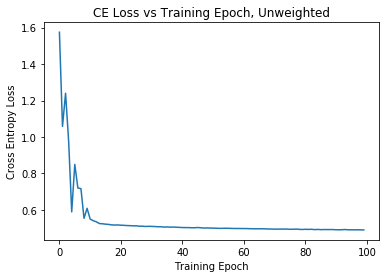

In [138]:
plt.plot(loss_tracker)
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Training Epoch")
plt.title("CE Loss vs Training Epoch, Unweighted")

Ok, we've gone through and gotten the model to work at least once, and it definitely looks reasonable --- continually decreasing loss with increasing time. It looks like lr of 0.1 or 0.01 works about the same, and comes to a loss of about 0.5 pretty quickly. Plot above shows this decently well, for lr = 0.1. 
All that being said, we need a train-test split still, so we can get things that are not loss. Then, we'll want to do a training epoch, into a testing epoch, and see how it performs at each epoch on a test set. 

In [168]:
linear_net = Net()

In [169]:
#Set up what we'll use as an optimizer, and call it optimizer
linear_optimizer = optim.SGD(linear_net.parameters(), lr = 0.1, momentum = 0.5)

In [81]:
#Now we need to make our training and testing tokens
train_NN_tokens, test_NN_tokens, train_NN_labels, test_NN_labels = train_test_split(no_pad_tokens, no_pad_labels)

In [82]:
#Ok, and then flip the training and testing tokens into a torch tensor.
torch_train_tokens = torch.tensor(train_NN_tokens, requires_grad = True)
torch_train_labels = torch.tensor(train_NN_labels)
torch_test_tokens = torch.tensor(test_NN_tokens, requires_grad = True)
torch_test_labels = torch.tensor(test_NN_labels)

In [172]:
train_loss_tracker = []
test_loss_tracker = []
test_predictions = []
test_accuracy_tracker = []
train_accuracy_tracker = []
#train for 100 epochs, cool. Lol it took like 30 seconds tops. 
for epoch in range(100):
    if epoch % 15 == 0:
        print("In epoch: ", epoch)
        flag = True
        
    else:
        flag = False
    
    linear_net.train()
    linear_optimizer.zero_grad()
    train_outputs = linear_net(torch_train_tokens)
    train_loss = criterion(train_outputs, torch_train_labels)
    train_loss.backward()
    linear_optimizer.step()
    #print(epoch)
    #Ok, we need some way to save the losses as we go. 
    train_loss_tracker.append(train_loss.item())
    #Really interesting to note that calc accuracy REALLY SLOWS THIS DOWN
    #Maybe sparsify accuracy to be ever 5 epochs?
    train_accuracy_tracker.append(flat_accuracy(train_outputs, torch_train_labels))
    
    #Once we've done a training step, then move to a testing step:
    linear_net.eval()
    #Make sure we don't have gradients going
    with torch.no_grad():
        test_outputs = linear_net(torch_test_tokens)
    
    #Ok, now calculate test_loss
    test_loss = criterion(test_outputs, torch_test_labels)
    test_loss_tracker.append(test_loss.item())
    
    
    numpy_test_outputs = test_outputs.detach().cpu().numpy()
    #Final step is to find some way to keep track of the model's predictions over time
    test_predictions.append(numpy_test_outputs)
    test_accuracy_tracker.append(flat_accuracy(numpy_test_outputs, torch_test_labels))

In epoch:  0
In epoch:  15
In epoch:  30
In epoch:  45
In epoch:  60
In epoch:  75
In epoch:  90


In [77]:
def plot_loss(test_loss_list, train_loss_list):
    "Takes in lists of the test and training losses, and makes a simple plot."
    plt.plot(test_loss_list, label = 'Test Loss')
    plt.plot(train_loss_list, label = 'Train Loss')
    plt.ylabel("Cross Entropy Loss")
    plt.xlabel("Training Epoch")
    plt.title("CE Loss vs Training Epoch, Unweighted")
    plt.legend()
    plt.show()

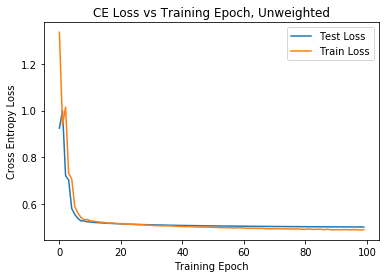

In [173]:
plt.plot(test_loss_tracker, label = 'Test Loss')
plt.plot(train_loss_tracker, label = 'Train Loss')
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Training Epoch")
plt.title("CE Loss vs Training Epoch, Unweighted")
plt.legend()
plt.show()

In [134]:
def plot_accuracy(test_accuracy_list, train_accuracy_list, ylim_min = 0.7, ylim_max = 1.05):
    "Function that takes in lists of testing and training accuracy and makes a simple plot"
    plt.plot(test_accuracy_list, label = 'Test Accuracy')
    plt.plot(train_accuracy_list, label = 'Train Accuracy')
    plt.ylabel("Flat Accuracy")
    plt.xlabel("Training Epoch")
    plt.ylim(ylim_min, ylim_max)
    plt.title("Accuracy vs Training Epoch, Unweighted")
    plt.legend()
    plt.show()

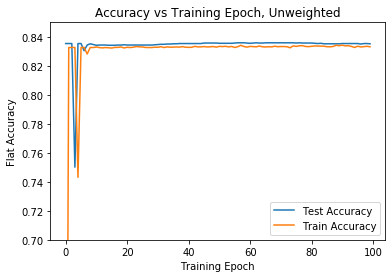

In [176]:
plt.plot(test_accuracy_tracker, label = 'Test Accuracy')
plt.plot(train_accuracy_tracker, label = 'Train Accuracy')
plt.ylabel("Flat Accuracy")
plt.xlabel("Training Epoch")
plt.ylim(0.7, 0.85)
plt.title("Accuracy vs Training Epoch, Unweighted")
plt.legend()
plt.show()

# Next two steps!
1. Make an accuracy function, and call it along the way. Implement both F1 and flat accuracy, just for kicks.
2. Make a weighted NN, and try training it to see how it does. 

Following these two steps, we can explore also adding biases, or subsampling outside tokens, or adding an additional network layer, or adding an activation layer or something like that. I'll probably also want to look into fine-tuning the BERT network, rather than just taking it's pre-loaded output.

In [160]:
no_pad_labels[1]

3

In [124]:
def flat_accuracy(predictions, labels):
    """This function takes in logits and labels and determines a flat accuracy."""
    correct_count = 0
    max_preds = np.zeros(shape = len(labels))
    
    #Find actual function guesses, not just logits
    for i in range(len(predictions)):
        max_preds[i] = np.where(predictions[i] == max(predictions[i]))[0]

    #Ok, the above finds the model's actual guess. Now we compare:
    for i in range(len(max_preds)):
        if max_preds[i] == labels[i]:
            correct_count += 1
            
    return correct_count/len(labels)    

In [166]:
flat_accuracy(test_predictions[-1], torch_test_labels)

0.8329907502569374

In [125]:
import pandas as pd

In [126]:
#Make a confusion matrix function:
def make_confusion_matrix(predictions, labels, prettify = False):
    """This function takes in logits and labels and determines a flat accuracy."""
    max_preds = np.zeros(shape = len(labels))
    
    #Find actual function guesses, not just logits
    for i in range(len(predictions)):
        max_preds[i] = np.where(predictions[i] == max(predictions[i]))[0]
        
    #Ok, now we make the confusion matrix:
    num_labels = len(set(labels))+1
    conf_mat = np.zeros(shape = (num_labels, num_labels))
    for j in range(len(labels)):
        conf_mat[int(labels[j])][int(max_preds[j])] += 1
    
    if prettify:
        confusion_matrix = prettify_confusion_matrix(conf_mat)
    else:
        confusion_matrix = conf_mat
    
    return confusion_matrix

In [127]:
def prettify_confusion_matrix(confusion_matrix):

    linear = np.linspace(0, len(confusion_matrix)-1, num = len(confusion_matrix), dtype = int)
    index = []
    for i in linear:
        index.append("Pred: " + str(i))
    conf_mat_df = pd.DataFrame(index = index)
    for i in range(len(confusion_matrix)):
        conf_mat_df['Act_labels: ' + str(i)] = confusion_matrix[i]
    return conf_mat_df

In [214]:
make_confusion_matrix(test_predictions[-1], torch_test_labels.numpy(), prettify = True)

,Act_labels: 0,Act_labels: 1,Act_labels: 2,Act_labels: 3
Pred: 0,0.0,0.0,0.0,0.0
Pred: 1,0.0,10.0,0.0,11.0
Pred: 2,0.0,0.0,0.0,0.0
Pred: 3,0.0,702.0,249.0,4866.0


****

# Weighted 1-Layer NN Classifier
Ok, it seems like the unweighted NN is not doing a great job of handling the unbalanced dataset. So, we'll introduce weighting into a new model and see how it performs. 

In [87]:
weighted_net = Net()

In [92]:
weighted_net.classifier.weight.shape

torch.Size([4, 768])

Ok, so we can see that we have a weight parameter that has a shape of 4 (ie the output token size) by 768 (ie the vector length). So, we'll need to introduce a function that make a vector based on the standard initialization of weight functions for torch modules (which I think is some sort of fan-shaped function, and which we've implemented in other places), then multiply each of those components by the component weights. It'll end up making it so that each weight is still essentially random, but each input will be increased by the presence of the class in the dataset. 

In [106]:
(small_label_mapping.values())

dict_values([3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0])

In [108]:
key_count_list = np.zeros(len(set(small_label_mapping.values())))
for i in range(len(no_pad_labels)):
    key_count_list[no_pad_labels[i]] += 1

In [111]:
key_count_list[0] += int(1)

In [112]:
key_count_list

array([1.0000e+00, 2.9040e+03, 9.8700e+02, 1.9459e+04])

In [113]:
list_o_weights = (sum(key_count_list)/(len(label_mapping.keys())*key_count_list))

In [114]:
list_o_weights

array([1.66792857e+03, 5.74355569e-01, 1.68989724e+00, 8.57150199e-02])

In [115]:
list_o_weights[0] = 0

In [119]:
#Gotta multiply the classifier weight by our calculated weight values for each vector weight. 
#list_o_weights is my previously calculated weight list set.
#I have no idea if position 0 in classifier.weight is weight for classification 0. I bet it is, but should check.
#Make our new blank canvas tensor
temp_tensor = torch.empty((len(set(small_label_mapping.values())), 768), requires_grad = True)
#Initialize our tensor with standard xavier_normal equation
torch.nn.init.xavier_normal_(temp_tensor)
print(temp_tensor)
#Turn off grad calcs so we don't track our weight changes.
#Then, we want to multiply the absolute weights from xavier init by our weight list calced earlier to get our
#final model weight values
with torch.no_grad():
    for i in range(len(temp_tensor)):
        temp_tensor[i] = (temp_tensor[i] * list_o_weights[i])     
#Check that the tensor got updated correctly
print(temp_tensor)
#Update the classifier weight with the new tensor
weighted_net.classifier.weight = torch.nn.Parameter(temp_tensor, requires_grad = True)

#Make sure it got updated correctly
print(weighted_net.classifier.weight)

tensor([[ 0.1080, -0.0611,  0.0115,  ...,  0.0294, -0.0280, -0.0268],
        [-0.0295, -0.0171, -0.0404,  ..., -0.0551,  0.0735,  0.0233],
        [-0.0499, -0.0256, -0.0353,  ...,  0.0664,  0.0013, -0.0070],
        [-0.0323, -0.0268,  0.0368,  ..., -0.0070,  0.0320, -0.0557]],
       requires_grad=True)
tensor([[ 0.0000, -0.0000,  0.0000,  ...,  0.0000, -0.0000, -0.0000],
        [-0.0170, -0.0098, -0.0232,  ..., -0.0316,  0.0422,  0.0134],
        [-0.0843, -0.0433, -0.0596,  ...,  0.1122,  0.0022, -0.0119],
        [-0.0028, -0.0023,  0.0032,  ..., -0.0006,  0.0027, -0.0048]],
       requires_grad=True)
Parameter containing:
tensor([[ 0.0000, -0.0000,  0.0000,  ...,  0.0000, -0.0000, -0.0000],
        [-0.0170, -0.0098, -0.0232,  ..., -0.0316,  0.0422,  0.0134],
        [-0.0843, -0.0433, -0.0596,  ...,  0.1122,  0.0022, -0.0119],
        [-0.0028, -0.0023,  0.0032,  ..., -0.0006,  0.0027, -0.0048]],
       requires_grad=True)


In [122]:
#Set up what we'll use as an optimizer, and call it optimizer
weighted_optimizer = optim.SGD(weighted_net.parameters(), lr = 0.1, momentum = 0.5)

In [128]:
train_loss_tracker = []
test_loss_tracker = []
test_predictions = []
test_accuracy_tracker = []
train_accuracy_tracker = []
#train for 100 epochs, cool. Lol it took like 30 seconds tops. 
for epoch in range(100):
    if epoch % 5 == 0:
        print("In epoch: ", epoch)
        flag = True
        
    else:
        flag = False
    
    weighted_net.train()
    weighted_optimizer.zero_grad()
    train_outputs = weighted_net(torch_train_tokens)
    train_loss = criterion(train_outputs, torch_train_labels)
    train_loss.backward()
    weighted_optimizer.step()
    #print(epoch)
    #Ok, we need some way to save the losses as we go. 
    train_loss_tracker.append(train_loss.item())
    #Really interesting to note that calc accuracy REALLY SLOWS THIS DOWN
    #Maybe sparsify accuracy to be ever 5 epochs?
    if flag:
        train_accuracy_tracker.append(flat_accuracy(train_outputs, torch_train_labels))
    
    #Once we've done a training step, then move to a testing step:
    weighted_net.eval()
    #Make sure we don't have gradients going
    with torch.no_grad():
        test_outputs = weighted_net(torch_test_tokens)
    
    #Ok, now calculate test_loss
    test_loss = criterion(test_outputs, torch_test_labels)
    test_loss_tracker.append(test_loss.item())
    
    
    numpy_test_outputs = test_outputs.detach().cpu().numpy()
    #Final step is to find some way to keep track of the model's predictions over time
    test_predictions.append(numpy_test_outputs)
    #This is slow, so call it infrequently
    if flag:
        test_accuracy_tracker.append(flat_accuracy(numpy_test_outputs, torch_test_labels))

In epoch:  0
In epoch:  5
In epoch:  10
In epoch:  15
In epoch:  20
In epoch:  25
In epoch:  30
In epoch:  35
In epoch:  40
In epoch:  45
In epoch:  50
In epoch:  55
In epoch:  60
In epoch:  65
In epoch:  70
In epoch:  75
In epoch:  80
In epoch:  85
In epoch:  90
In epoch:  95


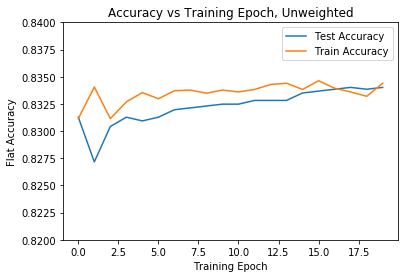

In [137]:
plot_accuracy(test_accuracy_tracker, train_accuracy_tracker, 0.82, 0.84)

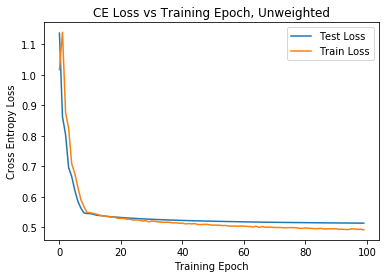

In [138]:
plot_loss(test_loss_tracker, train_loss_tracker)

Ok, this performance is a huge bummer, as adding weights just makes the network more stable, but doesn't actually change that it gets stuck at a certain level. This acutally makes me think that maybe the optimizer is the problem, and that maybe why we're having problems is that it gets stuck in a local minima, and can't get any better. 

Alternative problems could be either that the model isn't complex enough, that the data is too biased, or that I need to first run fine-tuning on the BERT encodings. 

To me, the BERT encodings seems the most likely to improve our overall performance. 

****

# 1 Layer Classifier with added bias, but no weight